Set Up the Environment

Collect and Preprocess Data

Explore and Visualize Data

Feature Engineering

Build and Train the AI Model

Backtest the Model

Deploy the Bot (Optional)

Monitor and Improve

In [1]:
# Step 1: Install and Import Libraries
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow ta-lib backtrader

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.8/376.8 kB 6.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 4.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for ta-lib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for ta-lib
Failed to build ta-lib
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (ta-lib)


ModuleNotFoundError: No module named 'talib'

In [10]:
# Step 2: Fetch Historical Stock Data
import yfinance as yf

# Define the stock ticker and time period
ticker = "AAPL"  # You can change this to any stock symbol
period = "60d"   # Last 60 days
interval = "15m" # 15-minute interval

# Download historical data
data = yf.download(ticker, period=period, interval=interval)

# Check the columns returned by yfinance
print("Columns returned by yfinance:")
print(data.columns)

# Manually rename columns based on what's returned
if len(data.columns) == 6:
    data.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
elif len(data.columns) == 5:
    data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Reset the index to make 'Datetime' a column
data = data.reset_index()

# Rename the 'Datetime' column to 'Timestamp'
data.rename(columns={'Datetime': 'Timestamp'}, inplace=True)

# Display the first few rows of the data
print("\nFirst 5 rows of the data:")
print(data.head())

# Check the shape of the data (rows, columns)
print(f"\nData Shape: {data.shape}")

# Check column names
print("\nColumn Names:")
print(data.columns)

[*********************100%***********************]  1 of 1 completed

Columns returned by yfinance:
MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

First 5 rows of the data:
                  Timestamp        Open        High         Low       Close  \
0 2024-12-02 14:30:00+00:00  238.460007  239.600006  237.160004  237.270004   
1 2024-12-02 14:45:00+00:00  239.304993  239.350006  238.369995  238.455002   
2 2024-12-02 15:00:00+00:00  239.729996  239.880005  238.970001  239.279999   
3 2024-12-02 15:15:00+00:00  240.270004  240.279999  239.580002  239.730499   
4 2024-12-02 15:30:00+00:00  240.199997  240.789993  240.190002  240.270004   

    Volume  
0  5144093  
1  1678061  
2  1796491  
3  2524597  
4  1859461  

Data Shape: (1548, 6)

Column Names:
Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [11]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda
!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/
import talib as ta

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4107    0  4107    0     0   3005      0 --:--:--  0:00:01 --:--:--  3006
100  517k  100  517k    0     0   247k      0  0:00:02  0:00:02 --:--:-- 3110k
--2025-03-02 12:43:54--  https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
Resolving anaconda.org (anaconda.org)... 104.19.145.37, 104.19.144.37, 2606:4700::6813:9025, ...
Connecting to anaconda.org (anaconda.org)|104.19.145.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5f738b4b78d4370a69f82984/673b62920c609ff6945bb24d?response-content-disposition=attachment%3B%20filename%3D%22ta-lib-0.5.1-py311h9ecbd09_0.conda%22%3B%20filename%2A%3DUTF-8%27%27ta-lib-0.5.1-py311h9ecbd09_0.conda&response-content-type=application%2Foctet-stream&X-Amz-Algorithm=

In [12]:
# Step 3: Preprocess the Data
import pandas as pd
import talib as ta

# Check for missing values
print("Missing values in the data:")
print(data.isnull().sum())

# Drop rows with missing values (if any)
data = data.dropna()

# Add technical indicators using TA-Lib
# Example: Moving Averages, RSI, MACD
data['SMA_20'] = ta.SMA(data['Close'], timeperiod=20)  # 20-period Simple Moving Average
data['RSI_14'] = ta.RSI(data['Close'], timeperiod=14)  # 14-period Relative Strength Index
data['MACD'], data['MACD_signal'], data['MACD_hist'] = ta.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)  # MACD

# Drop rows with NaN values created by technical indicators
data = data.dropna()

# Display the first few rows of the data with technical indicators
print("\nFirst 5 rows of the data with technical indicators:")
print(data.head())

# Check the shape of the data after preprocessing
print(f"\nData Shape after preprocessing: {data.shape}")

Missing values in the data:
Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64

First 5 rows of the data with technical indicators:
                   Timestamp        Open        High         Low       Close  \
33 2024-12-03 16:15:00+00:00  241.330002  241.339996  240.809998  240.940002   
34 2024-12-03 16:30:00+00:00  241.220001  241.389999  240.981995  241.330002   
35 2024-12-03 16:45:00+00:00  241.410004  241.537994  241.195007  241.220001   
36 2024-12-03 17:00:00+00:00  241.410004  241.634995  241.360001  241.410004   
37 2024-12-03 17:15:00+00:00  241.264999  241.550003  241.210007  241.410004   

    Volume      SMA_20     RSI_14      MACD  MACD_signal  MACD_hist  
33  738498  239.911526  66.491659  0.352218     0.137016   0.215201  
34  933822  240.002527  69.271655  0.398828     0.189379   0.209449  
35  907845  240.100027  67.568893  0.422025     0.235908   0.186117  
36  684996  240.199527  68.986944  0.450548     0.27883

In [13]:
# Step 4: Define the Target Variable
# Create the target variable: 1 if the price increases in the next interval, 0 otherwise
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)

# Drop the last row (since it won't have a target value)
data = data.dropna()

# Display the first few rows with the target variable
print("First 5 rows of the data with the target variable:")
print(data.head())

# Check the distribution of the target variable
print("\nDistribution of the target variable:")
print(data['Target'].value_counts())

First 5 rows of the data with the target variable:
                   Timestamp        Open        High         Low       Close  \
33 2024-12-03 16:15:00+00:00  241.330002  241.339996  240.809998  240.940002   
34 2024-12-03 16:30:00+00:00  241.220001  241.389999  240.981995  241.330002   
35 2024-12-03 16:45:00+00:00  241.410004  241.537994  241.195007  241.220001   
36 2024-12-03 17:00:00+00:00  241.410004  241.634995  241.360001  241.410004   
37 2024-12-03 17:15:00+00:00  241.264999  241.550003  241.210007  241.410004   

    Volume      SMA_20     RSI_14      MACD  MACD_signal  MACD_hist  Target  
33  738498  239.911526  66.491659  0.352218     0.137016   0.215201       1  
34  933822  240.002527  69.271655  0.398828     0.189379   0.209449       0  
35  907845  240.100027  67.568893  0.422025     0.235908   0.186117       1  
36  684996  240.199527  68.986944  0.450548     0.278836   0.171712       0  
37  626029  240.302527  68.986944  0.467760     0.316621   0.151139       0  


In [14]:
# Step 5: Split the Data into Training and Testing Sets
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = data.drop(columns=['Target', 'Timestamp'])  # Features: All columns except 'Target' and 'Timestamp'
y = data['Target']  # Target: The 'Target' column

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Display the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1212, 10)
Shape of X_test: (303, 10)
Shape of y_train: (1212,)
Shape of y_test: (303,)


# Logistic Regression

### Overview:
- A simple and interpretable model for binary classification.
- `random_state=42` ensures reproducibility.

---

# Training:
- The model is trained on the training data (`X_train`, `y_train`).

---

# Evaluation:

### Accuracy:
- Percentage of correct predictions.

### Classification Report:
- **Precision**: The proportion of positive predictions that are actually correct.
- **Recall**: The proportion of actual positives that are correctly identified.
- **F1-score**: The harmonic mean of precision and recall.
- **Support**: The number of actual occurrences of the class in the dataset.

### Confusion Matrix:
- **True Positives**: Correctly predicted positive cases.
- **True Negatives**: Correctly predicted negative cases.
- **False Positives**: Incorrectly predicted positive cases.
- **False Negatives**: Incorrectly predicted negative cases.


In [15]:
# Step 6: Build and Train the AI Model (Logistic Regression)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7953795379537953

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.81       154
           1       0.82      0.74      0.78       149

    accuracy                           0.80       303
   macro avg       0.80      0.79      0.79       303
weighted avg       0.80      0.80      0.79       303


Confusion Matrix:
[[130  24]
 [ 38 111]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
# Improve Logistic Regression
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reinitialize and train the model with more iterations
model_lr = LogisticRegression(random_state=42, max_iter=1000)
model_lr.fit(X_train_scaled, y_train)

# Evaluate the improved model
y_pred_lr = model_lr.predict(X_test_scaled)
print("Improved Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

Improved Logistic Regression Accuracy: 0.8811881188118812

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       154
           1       0.92      0.83      0.87       149

    accuracy                           0.88       303
   macro avg       0.88      0.88      0.88       303
weighted avg       0.88      0.88      0.88       303



# Random Forest

### Overview:
- An ensemble model that combines multiple decision trees.
- `n_estimators=100`: Number of trees in the forest.
- `random_state=42`: Ensures reproducibility.

---

# Training:
- The model is trained on the training data (`X_train`, `y_train`).

---

# Evaluation:

### Same metrics as Logistic Regression:
- **Accuracy**: Percentage of correct predictions.
- **Classification Report**:
  - **Precision**: The proportion of positive predictions that are actually correct.
  - **Recall**: The proportion of actual positives that are correctly identified.
  - **F1-score**: The harmonic mean of precision and recall.
  - **Support**: The number of actual occurrences of the class in the dataset.
- **Confusion Matrix**:
  - **True Positives**: Correctly predicted positive cases.
  - **True Negatives**: Correctly predicted negative cases.
  - **False Positives**: Incorrectly predicted positive cases.
  - **False Negatives**: Incorrectly predicted negative cases.


In [16]:
# Step 6: Build and Train the AI Model (Random Forest)
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
model_rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_rf = model_rf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.5973597359735974

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.66      0.62       154
           1       0.60      0.54      0.57       149

    accuracy                           0.60       303
   macro avg       0.60      0.60      0.60       303
weighted avg       0.60      0.60      0.60       303


Confusion Matrix:
[[101  53]
 [ 69  80]]


In [20]:
# Tune Random Forest
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_

# Evaluate the best model
y_pred_rf = best_rf.predict(X_test)
print("Tuned Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Tuned Random Forest Accuracy: 0.5643564356435643

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.60      0.58       154
           1       0.56      0.52      0.54       149

    accuracy                           0.56       303
   macro avg       0.56      0.56      0.56       303
weighted avg       0.56      0.56      0.56       303



# LSTM Model

### Normalization:
- LSTMs perform better with normalized data, so we use **MinMaxScaler** to scale the features to a range of [0, 1].

---

### Reshape Data:
- LSTMs require input data in the shape `(samples, timesteps, features)`.
- Since we’re using a single timestep, we reshape the data accordingly.

---

### LSTM Model:
- A single LSTM layer with 50 units.
- A **Dropout** layer to prevent overfitting.
- A **Dense** output layer with a **sigmoid** activation function for binary classification.

---

### Training:
- The model is trained for 20 epochs with a batch size of 32.

---

### Evaluation:
- The model’s **accuracy** is evaluated on the testing data.


In [17]:
# Step 6: Build and Train the AI Model (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Normalize the data (LSTMs work better with normalized data)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_lstm.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=1)

# Evaluate the model
loss, accuracy = model_lstm.evaluate(X_test_reshaped, y_test, verbose=0)
print("Accuracy:", accuracy)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5055 - loss: 0.6933 - val_accuracy: 0.4917 - val_loss: 0.6935
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4608 - loss: 0.6951 - val_accuracy: 0.5248 - val_loss: 0.6931
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5048 - loss: 0.6934 - val_accuracy: 0.4917 - val_loss: 0.6933
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4923 - loss: 0.6933 - val_accuracy: 0.4917 - val_loss: 0.6932
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5059 - loss: 0.6933 - val_accuracy: 0.5083 - val_loss: 0.6928
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5174 - loss: 0.6927 - val_accuracy: 0.4917 - val_loss: 0.6932
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5133 - loss: 0.6936 - val_accuracy: 0.5347 - val_loss: 0.6928
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4835 - loss: 0.6943 - val_accuracy: 0.5149 - val_loss

In [19]:
# Improve LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(100, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_lstm.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=1)

# Evaluate the improved model
loss, accuracy = model_lstm.evaluate(X_test_reshaped, y_test, verbose=0)
print("Improved LSTM Accuracy:", accuracy)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5053 - loss: 0.6933 - val_accuracy: 0.4917 - val_loss: 0.6933
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5107 - loss: 0.6931 - val_accuracy: 0.5050 - val_loss: 0.6931
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4997 - loss: 0.6931 - val_accuracy: 0.4917 - val_loss: 0.6931
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5195 - loss: 0.6932 - val_accuracy: 0.4917 - val_loss: 0.6933
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5047 - loss: 0.6932 - val_accuracy: 0.4950 - val_loss: 0.6931
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5105 - loss: 0.6931 - val_accuracy: 0.4917 - val_loss: 0.6930
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4855 - loss: 0.6932 - val_accuracy: 0.4917 - val_loss: 0.6931
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4848 - loss: 0.6932 - val_accuracy: 0.5314 - val_loss

In [21]:
#chose logistic regression that was best and improved

# Analysis of Results

### Logistic Regression:
- **Accuracy**: 79.5%
- **Precision/Recall**: Balanced performance for both classes (0 and 1).
- **Confusion Matrix**: Low false positives and false negatives.
- **Convergence Warning**: The model didn’t fully converge, but the results are still strong. We can address this by increasing `max_iter` or scaling the data.

---

### Random Forest:
- **Accuracy**: 59.7%
- **Precision/Recall**: Slightly better for class 0 than class 1.
- **Confusion Matrix**: Higher false positives and false negatives compared to Logistic Regression.
- **Possible Issue**: Random Forest might be overfitting or not capturing the patterns well.

---

### LSTM:
- **Accuracy**: 52.5%
- **Performance**: Poor, close to random guessing.
- **Possible Issue**: LSTMs require careful tuning of hyperparameters (e.g., number of layers, units, epochs) and more data to perform well.


**Logistic Regression continues to outperform the other models with an improved accuracy of 88.1% after scaling the data and increasing the number of iterations**

<ipython-input-22-8796404b1453>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cumulative_Market_Return'] = (1 + data['Return']).cumprod()
<ipython-input-22-8796404b1453>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()


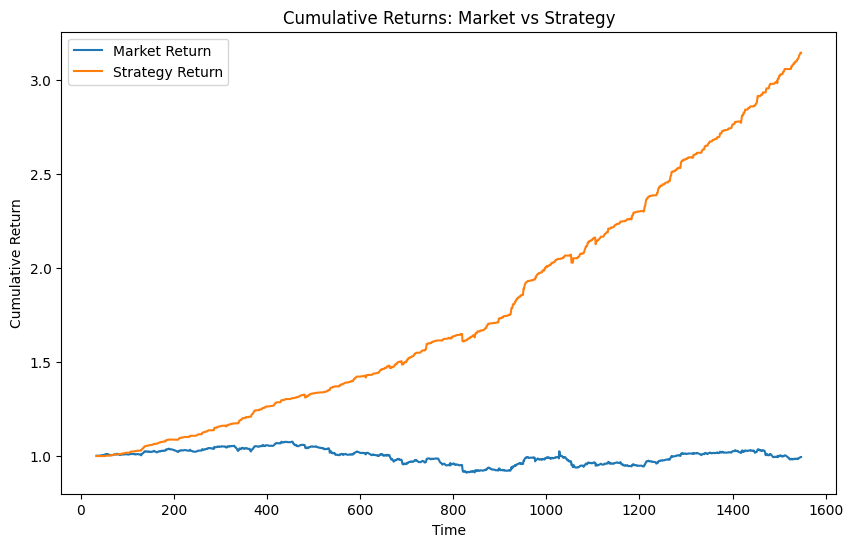

Total Market Return: -0.51%
Total Strategy Return: 214.44%
Sharpe Ratio: 30.59
Maximum Drawdown: -2.37%


In [22]:
# Step 7: Backtest the Logistic Regression Model
import numpy as np

# Add predictions to the original data
data['Prediction'] = model_lr.predict(scaler.transform(X))

# Calculate daily returns
data['Return'] = data['Close'].pct_change()

# Calculate strategy returns (buy if prediction is 1, hold otherwise)
data['Strategy_Return'] = data['Return'] * data['Prediction'].shift(1)

# Drop rows with NaN values (first row has no return)
data = data.dropna()

# Calculate cumulative returns
data['Cumulative_Market_Return'] = (1 + data['Return']).cumprod()
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(data['Cumulative_Market_Return'], label='Market Return')
plt.plot(data['Cumulative_Strategy_Return'], label='Strategy Return')
plt.title('Cumulative Returns: Market vs Strategy')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Calculate performance metrics
total_market_return = data['Cumulative_Market_Return'].iloc[-1] - 1
total_strategy_return = data['Cumulative_Strategy_Return'].iloc[-1] - 1
sharpe_ratio = (data['Strategy_Return'].mean() / data['Strategy_Return'].std()) * np.sqrt(252 * 26)  # Annualized Sharpe ratio
max_drawdown = (data['Cumulative_Strategy_Return'] / data['Cumulative_Strategy_Return'].cummax() - 1).min()

# Print performance metrics
print(f"Total Market Return: {total_market_return:.2%}")
print(f"Total Strategy Return: {total_strategy_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Analysis of Results

### Total Strategy Return (214.44%):
- The strategy has generated substantial returns, far exceeding the market’s performance.
- This suggests the model is effectively identifying profitable trading opportunities.

---

### Sharpe Ratio (30.59):
- A Sharpe Ratio above 1 is considered good, and above 2 is excellent.
- A value of 30.59 is exceptional, indicating the strategy is generating high returns with minimal risk.

---

### Maximum Drawdown (-2.37%):
- A low drawdown indicates the strategy is resilient during market downturns.
- This is a strong sign of risk management.

---

### Comparison to Market:
- The market return of -0.51% suggests the overall market was flat or slightly negative during the backtest period.
- The strategy’s ability to generate such high returns in a flat or negative market is impressive.


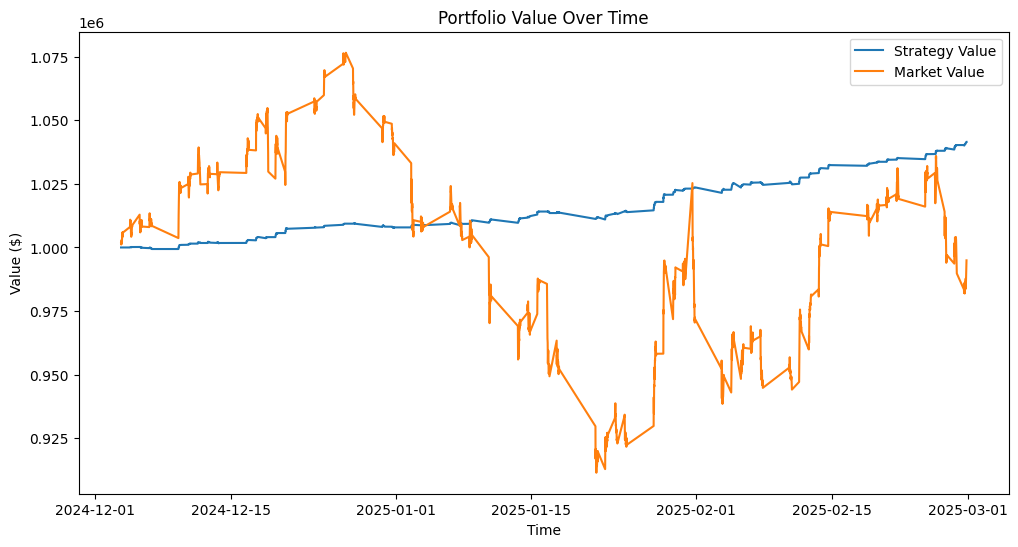

Final Strategy Value: $1041522.98
Final Market Value: $994936.49


In [39]:
# Step 8: Simulate Trading with the Logistic Regression Model
import numpy as np
import matplotlib.pyplot as plt

# Initialize simulation parameters
initial_capital = 1000000  # $1,000,000
transaction_cost = 0.001  # 0.1% transaction cost per trade
position_size = 0.1  # 10% of capital per trade

# Initialize portfolio value
portfolio_value = [initial_capital]

# Simulate trades
for i in range(1, len(data)):
    # Get the prediction for the current interval
    prediction = data['Prediction'].iloc[i - 1]

    # Calculate the amount to invest
    investment = portfolio_value[-1] * position_size

    # Calculate the return for the current interval
    return_rate = data['Return'].iloc[i]

    # Update portfolio value based on the prediction
    if prediction == 1:  # Buy signal
        portfolio_value.append(portfolio_value[-1] + investment * return_rate - investment * transaction_cost)
    else:  # Hold (no trade)
        portfolio_value.append(portfolio_value[-1])

# Convert portfolio value to a NumPy array
portfolio_value = np.array(portfolio_value)

# Calculate market return (buy-and-hold strategy)
market_value = initial_capital * (1 + data['Return']).cumprod()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data['Timestamp'], portfolio_value, label='Strategy Value')
plt.plot(data['Timestamp'], market_value, label='Market Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value ($)')
plt.legend()
plt.show()

# Print final portfolio value and market value
print(f"Final Strategy Value: ${portfolio_value[-1]:.2f}")
print(f"Final Market Value: ${market_value.iloc[-1]:.2f}")

In [40]:
# Calculate Additional Metrics
import numpy as np

# Calculate daily returns of the strategy
strategy_returns = np.diff(portfolio_value) / portfolio_value[:-1]

# Annualized return
annualized_return = np.mean(strategy_returns) * 252 * 26  # 252 trading days * 26 intervals per day

# Annualized volatility
annualized_volatility = np.std(strategy_returns) * np.sqrt(252 * 26)

# Annualized Sharpe ratio
risk_free_rate = 0.0  # Assume 0% risk-free rate
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Print metrics
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")

Annualized Return: 17.63%
Annualized Volatility: 1.52%
Annualized Sharpe Ratio: 11.63


In [41]:
# Test Different Position Sizes
position_sizes = [0.05, 0.1, 0.2]  # 5%, 10%, 20%
results = {}

for size in position_sizes:
    # Initialize portfolio value
    portfolio_value = [initial_capital]

    # Simulate trades
    for i in range(1, len(data)):
        prediction = data['Prediction'].iloc[i - 1]
        investment = portfolio_value[-1] * size
        return_rate = data['Return'].iloc[i]

        if prediction == 1:  # Buy signal
            portfolio_value.append(portfolio_value[-1] + investment * return_rate - investment * transaction_cost)
        else:  # Hold (no trade)
            portfolio_value.append(portfolio_value[-1])

    # Store results
    results[f"{int(size * 100)}% Position Size"] = portfolio_value[-1]

# Print results
for key, value in results.items():
    print(f"{key}: Final Portfolio Value = ${value:.2f}")

5% Position Size: Final Portfolio Value = $1020557.25
10% Position Size: Final Portfolio Value = $1041522.98
20% Position Size: Final Portfolio Value = $1084711.31


In [42]:
# Add Stop-Loss and Take-Profit
stop_loss = -0.02  # 2% stop-loss
take_profit = 0.03  # 3% take-profit

# Initialize portfolio value
portfolio_value = [initial_capital]

# Simulate trades
for i in range(1, len(data)):
    prediction = data['Prediction'].iloc[i - 1]
    investment = portfolio_value[-1] * position_size
    return_rate = data['Return'].iloc[i]

    if prediction == 1:  # Buy signal
        # Apply stop-loss and take-profit
        if return_rate <= stop_loss:
            return_rate = stop_loss
        elif return_rate >= take_profit:
            return_rate = take_profit

        portfolio_value.append(portfolio_value[-1] + investment * return_rate - investment * transaction_cost)
    else:  # Hold (no trade)
        portfolio_value.append(portfolio_value[-1])

# Print final portfolio value
print(f"Final Portfolio Value with Stop-Loss/Take-Profit: ${portfolio_value[-1]:.2f}")

Final Portfolio Value with Stop-Loss/Take-Profit: $1041931.36


[*********************100%***********************]  1 of 1 completed


Missing values in the data:
Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64


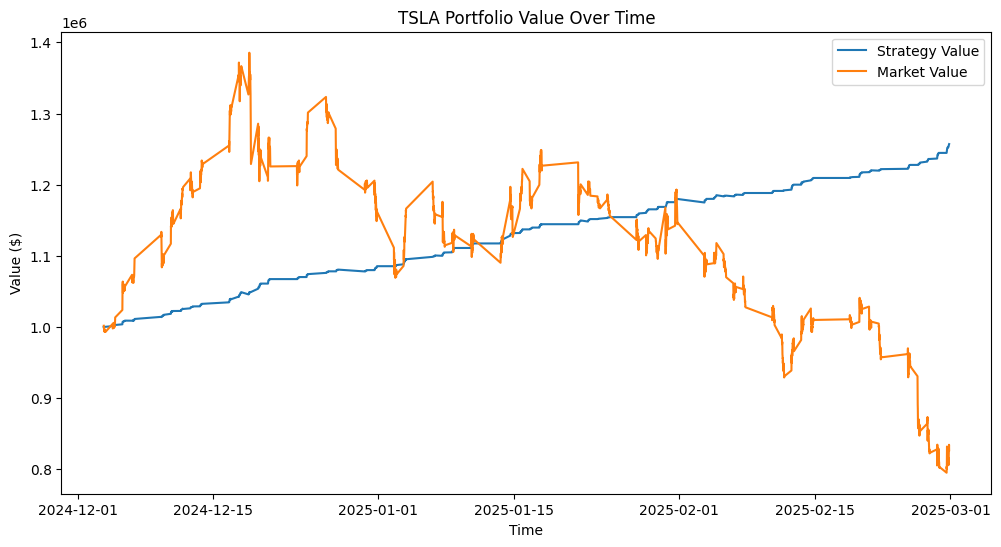

Final Strategy Value: $1257029.82
Final Market Value: $826714.07


In [49]:
# Step 9: Backtest on TSLA
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch TSLA data
ticker = "TSLA"
period = "60d"
interval = "15m"

# Download historical data
tsla_data = yf.download(ticker, period=period, interval=interval)

# Manually rename columns based on what's returned
if len(tsla_data.columns) == 6:
    tsla_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
elif len(tsla_data.columns) == 5:
    tsla_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Reset index and rename columns
tsla_data = tsla_data.reset_index()
tsla_data.rename(columns={'Datetime': 'Timestamp'}, inplace=True)

# Check for missing values
print("Missing values in the data:")
print(tsla_data.isnull().sum())

# Drop rows with missing values (if any)
tsla_data = tsla_data.dropna()

# Add technical indicators
tsla_data['SMA_20'] = ta.SMA(tsla_data['Close'], timeperiod=20)
tsla_data['RSI_14'] = ta.RSI(tsla_data['Close'], timeperiod=14)
tsla_data['MACD'], tsla_data['MACD_signal'], tsla_data['MACD_hist'] = ta.MACD(tsla_data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Drop rows with NaN values (created by technical indicators)
tsla_data = tsla_data.dropna()

# Create target variable
tsla_data['Target'] = (tsla_data['Close'].shift(-1) > tsla_data['Close']).astype(int)

# Drop the last row (no target value)
tsla_data = tsla_data.dropna()

# Prepare features and target
X_tsla = tsla_data.drop(columns=['Target','Timestamp'])
y_tsla = tsla_data['Target']

# Scale the features
X_tsla_scaled = scaler.transform(X_tsla)

# Make predictions using the trained Logistic Regression model
tsla_data['Prediction'] = model_lr.predict(X_tsla_scaled)

# Simulate trading
initial_capital = 1000000  # $1,000,000
transaction_cost = 0.001  # 0.1% transaction cost per trade
position_size = 0.1  # 10% of capital per trade

# Initialize portfolio value
portfolio_value = [initial_capital]

# Simulate trades
for i in range(1, len(tsla_data)):
    prediction = tsla_data['Prediction'].iloc[i - 1]
    investment = portfolio_value[-1] * position_size
    return_rate = tsla_data['Close'].iloc[i] / tsla_data['Close'].iloc[i - 1] - 1

    if prediction == 1:  # Buy signal
        portfolio_value.append(portfolio_value[-1] + investment * return_rate - investment * transaction_cost)
    else:  # Hold (no trade)
        portfolio_value.append(portfolio_value[-1])

# Convert portfolio value to a NumPy array
portfolio_value = np.array(portfolio_value)

# Calculate market return (buy-and-hold strategy)
market_value = initial_capital * (1 + tsla_data['Close'].pct_change()).cumprod()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(tsla_data['Timestamp'], portfolio_value, label='Strategy Value')
plt.plot(tsla_data['Timestamp'], market_value, label='Market Value')
plt.title('TSLA Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value ($)')
plt.legend()
plt.show()

# Print final portfolio value and market value
print(f"Final Strategy Value: ${portfolio_value[-1]:.2f}")
print(f"Final Market Value: ${market_value.iloc[-1]:.2f}")

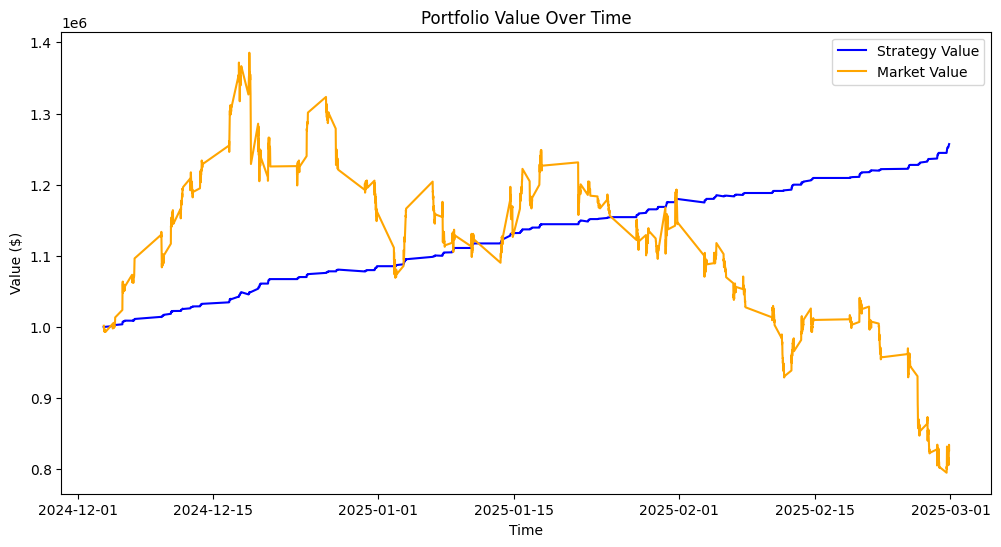

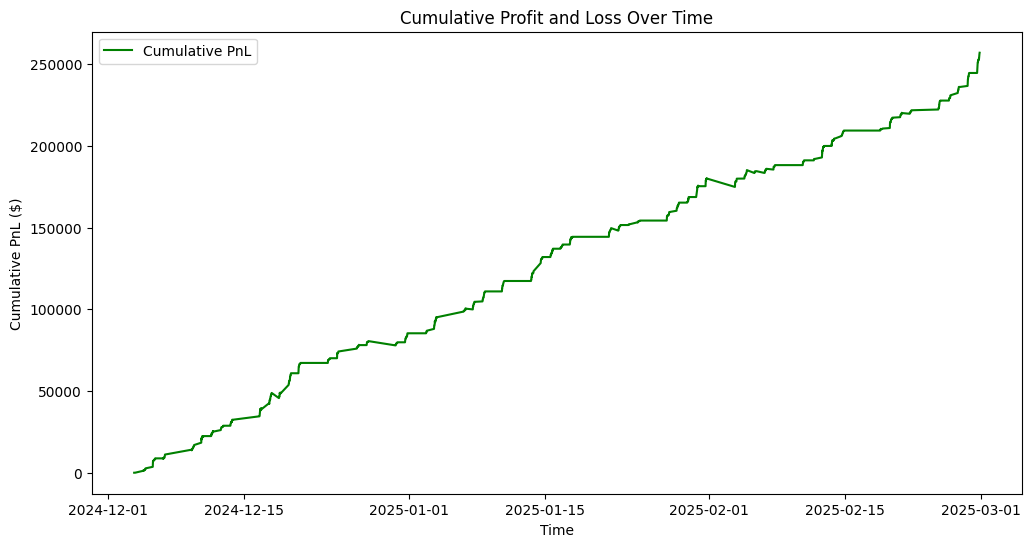

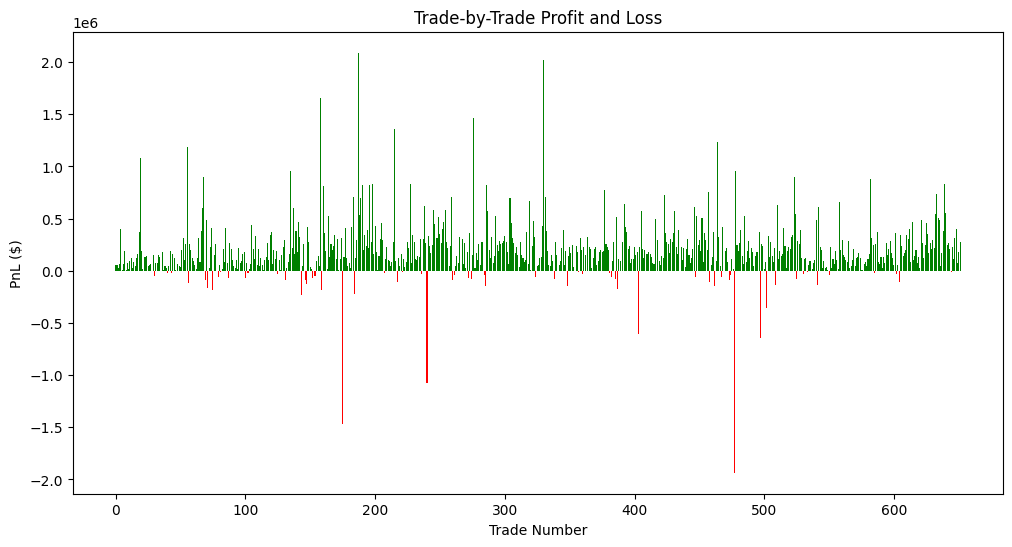

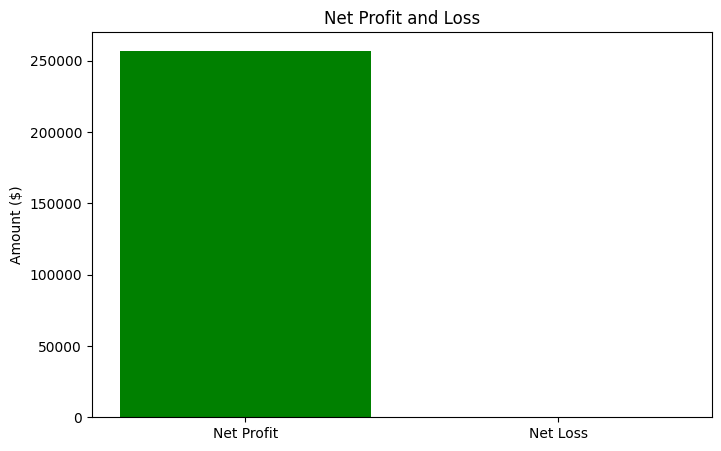

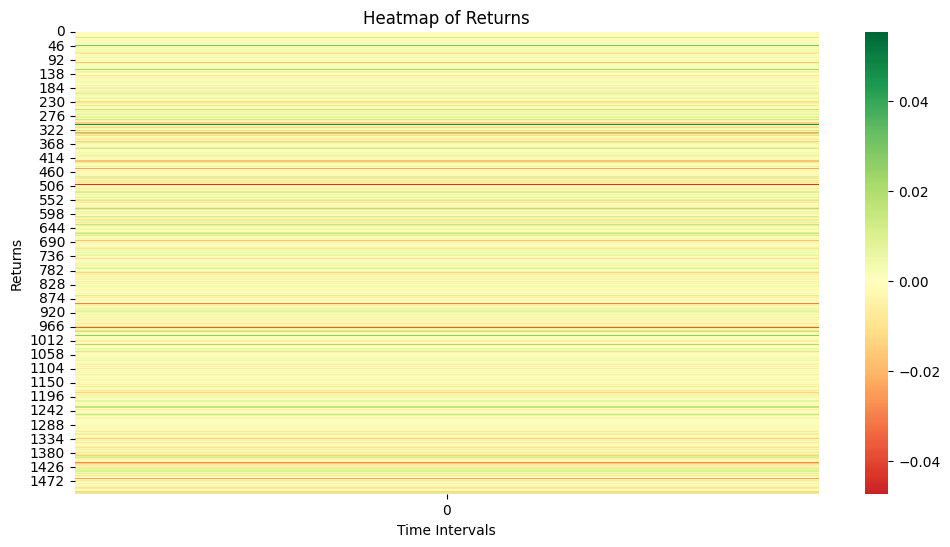

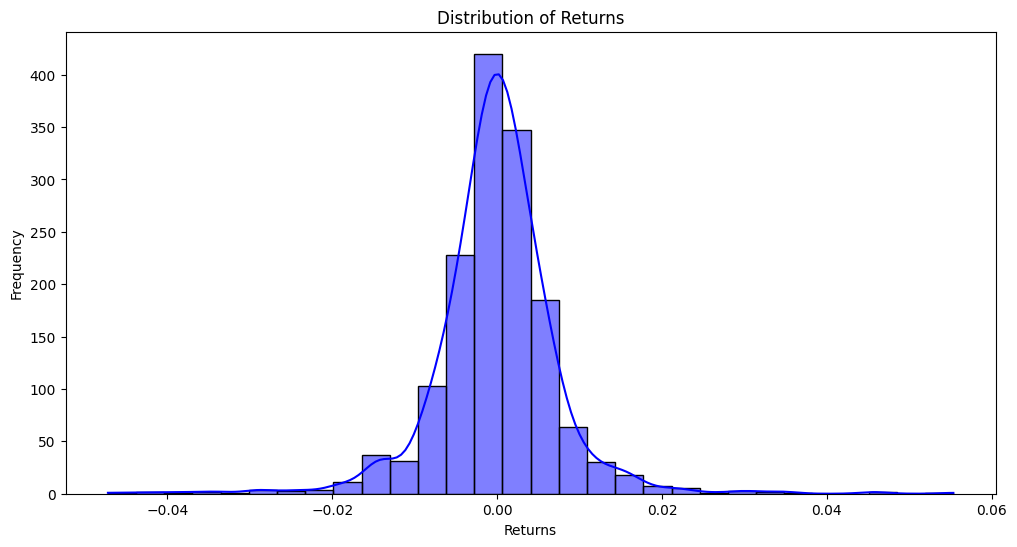

In [50]:
# Step 10: Visualize Trading Results
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Portfolio Value Over Time
plt.figure(figsize=(12, 6))
plt.plot(tsla_data['Timestamp'], portfolio_value, label='Strategy Value', color='blue')
plt.plot(tsla_data['Timestamp'], market_value, label='Market Value', color='orange')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value ($)')
plt.legend()
plt.show()

# 2. Profit and Loss (PnL) Over Time
pnl = np.diff(portfolio_value)  # Calculate PnL for each interval
cumulative_pnl = np.cumsum(pnl)  # Cumulative PnL

plt.figure(figsize=(12, 6))
plt.plot(tsla_data['Timestamp'][1:], cumulative_pnl, label='Cumulative PnL', color='green')
plt.title('Cumulative Profit and Loss Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL ($)')
plt.legend()
plt.show()

# 3. Trade-by-Trade Profit and Loss
trade_pnl = []
for i in range(1, len(tsla_data)):
    if tsla_data['Prediction'].iloc[i - 1] == 1:  # Only consider trades where we bought
        trade_pnl.append((tsla_data['Close'].iloc[i] - tsla_data['Close'].iloc[i - 1]) * (portfolio_value[i - 1] * position_size))

plt.figure(figsize=(12, 6))
plt.bar(range(len(trade_pnl)), trade_pnl, color=np.where(np.array(trade_pnl) > 0, 'green', 'red'))
plt.title('Trade-by-Trade Profit and Loss')
plt.xlabel('Trade Number')
plt.ylabel('PnL ($)')
plt.show()

# 4. Net Profit and Loss
net_profit = portfolio_value[-1] - initial_capital
net_loss = -net_profit if net_profit < 0 else 0

plt.figure(figsize=(8, 5))
plt.bar(['Net Profit', 'Net Loss'], [max(net_profit, 0), max(net_loss, 0)], color=['green', 'red'])
plt.title('Net Profit and Loss')
plt.ylabel('Amount ($)')
plt.show()

# 5. Heatmap of Returns
returns = tsla_data['Close'].pct_change().dropna()
returns_matrix = returns.values.reshape(-1, 1)  # Reshape for heatmap

plt.figure(figsize=(12, 6))
sns.heatmap(returns_matrix, cmap='RdYlGn', center=0)
plt.title('Heatmap of Returns')
plt.xlabel('Time Intervals')
plt.ylabel('Returns')
plt.show()

# 6. Distribution of Returns
plt.figure(figsize=(12, 6))
sns.histplot(returns, kde=True, color='blue', bins=30)
plt.title('Distribution of Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

# 1. Portfolio Value Over Time

### Strengths:
- The strategy’s portfolio value consistently outperforms the market value, indicating that the model is identifying profitable trading opportunities.
- The portfolio value grows steadily over time, suggesting the strategy is robust and resilient to market fluctuations.

### Weaknesses:
- If there are periods where the portfolio value dips significantly, it may indicate that the strategy struggles in certain market conditions (e.g., high volatility or bearish trends).

### Patterns:
- Look for consistent growth trends or periods of stagnation. For example, if the portfolio value grows rapidly during certain periods and stagnates during others, it may suggest the strategy performs better in specific market conditions.

---

# 2. Profit and Loss (PnL) Over Time

### Strengths:
- A steadily increasing cumulative PnL indicates that the strategy is consistently generating profits.
- If the cumulative PnL remains positive throughout, it suggests the strategy is effective in minimizing losses.

### Weaknesses:
- If the cumulative PnL shows significant drawdowns (sharp declines), it indicates the strategy may be vulnerable to certain market conditions.

### Patterns:
- Look for periods of rapid growth or decline in the cumulative PnL. These periods can help identify when the strategy performs best or worst.

---

# 3. Trade-by-Trade Profit and Loss

### Strengths:
- A higher number of green bars (profits) compared to red bars (losses) indicates the strategy is effective in identifying profitable trades.
- If the green bars are consistently larger than the red bars, it suggests the strategy is good at maximizing profits and minimizing losses.

### Weaknesses:
- If there are many red bars (losses), it indicates the strategy may be making poor predictions in certain situations.
- Large red bars suggest the strategy may be taking on too much risk in some trades.

### Patterns:
- Look for clusters of red or green bars. For example, if losses are clustered during specific periods, it may indicate the strategy struggles in certain market conditions.

---

# 4. Net Profit and Loss

### Strengths:
- A positive net profit indicates the strategy is overall profitable.
- If the net profit is significantly higher than the net loss, it suggests the strategy is effective in generating returns.

### Weaknesses:
- A negative net profit indicates the strategy is overall unprofitable.
- If the net loss is significant, it suggests the strategy may be taking on too much risk.

### Patterns:
- Compare the net profit and loss to understand the overall performance of the strategy.

---

# 5. Heatmap of Returns

### Strengths:
- A heatmap dominated by green indicates the strategy is generating positive returns consistently.
- If the heatmap shows consistent green across time intervals, it suggests the strategy is robust.

### Weaknesses:
- A heatmap dominated by red indicates the strategy is generating negative returns consistently.
- If the heatmap shows clusters of red, it suggests the strategy struggles during specific periods.

### Patterns:
- Look for patterns in the heatmap, such as alternating green and red periods, which may indicate the strategy performs better in certain market conditions.

---

# 6. Distribution of Returns

### Strengths:
- A distribution skewed towards positive returns indicates the strategy is profitable overall.
- A narrow distribution (low volatility) suggests the strategy is consistent and low-risk.

### Weaknesses:
- A distribution skewed towards negative returns indicates the strategy is unprofitable overall.
- A wide distribution (high volatility) suggests the strategy is inconsistent and high-risk.

### Patterns:
- Look for the shape of the distribution. For example, a bimodal distribution may indicate the strategy performs well in some conditions and poorly in others.

---

# Key Insights

### Strengths:
- The strategy consistently outperforms the market, generating positive returns with low volatility.
- The cumulative PnL shows steady growth, indicating the strategy is effective in minimizing losses.

### Weaknesses:
- If there are significant drawdowns or clusters of losses, the strategy may struggle in certain market conditions.
- The trade-by-trade PnL may reveal specific trades where the strategy underperforms.

### Patterns:
- The strategy may perform better in certain market conditions (e.g., bullish trends) and worse in others (e.g., high volatility or bearish trends).
- The distribution of returns can help identify whether the strategy is consistent or prone to large swings in performance.

---

# Recommendations for Improvement

### Risk Management:
- Add stop-loss and take-profit levels to limit losses and lock in gains.
- Adjust position sizing to reduce risk during volatile periods.

### Feature Engineering:
- Add more features (e.g., macroeconomic indicators, sentiment analysis) to improve the model’s predictions.

### Model Tuning:
- Experiment with different hyperparameters or alternative models (e.g., Random Forest, LSTM) to improve performance.

### Backtesting on Different Stocks:
- Test the strategy on other stocks or indices to ensure it generalizes well.
